# Density test
Here, we compare the two unmatched networks by treating each as an Erdos-Renyi network
and simply compare their estimated densities.

## The Erdos-Renyi (ER) model
The [**Erdos-Renyi (ER) model**
](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)
is one of the simplest network models. This model treats
the probability of each potential edge in the network occuring to be the same. In
other words, all edges between any two nodes are equally likely.

```{admonition} Math
Let $n$ be the number of nodes. We say that for all $(i, j), i \neq j$, with $i$ and
$j$ both running
from $1 ... n$, the probability of the edge $(i, j)$ occuring is:

$$ P[A_{ij} = 1] = p_{ij} = p $$

Where $p$ is the the global connection probability.

Each element of the adjacency matrix $A$ is then sampled independently according to a
[Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution):

$$ A_{ij} \sim Bernoulli(p) $$

For a network modeled as described above, we say it is distributed

$$ A \sim ER(n, p) $$

```

Thus, for this model, the only parameter of interest is the global connection
probability, $p$. This is sometimes also referred to as the **network density**.

## Testing under the ER model
In order to compare two networks $A^{(L)}$ and $A^{(R)}$ under this model, we
simply need to compute these network densities ($p^{(L)}$ and $p^{(R)}$), and then
run a statistical test to see if these densities are significantly different.

```{admonition} Math
Under this
model, the total number of edges $m$ comes from a $Binomial(n(n-1), p)$ distribution,
where $n$ is the number of nodes. This is because the number of edges is the sum of
independent Bernoulli trials with the same probability. If $m^{(L)}$ is the number of
edges on the left
hemisphere, and $m^{(R)}$ is the number of edges on the right, then we have:

$$m^{(L)} \sim Binomial(n^{(L)}(n^{(L)} - 1), p^{(L)})$$

and independently,

$$m^{(R)} \sim Binomial(n^{(R)}(n^{(R)} - 1), p^{(R)})$$

To compare the two networks, we are just interested in a comparison of $p^{(L)}$ vs.
$p^{(R)}$. Formally, we are testing:

$$H_0: p^{(L)} = p^{(R)}, \quad H_a: p^{(L)} \neq p^{(R)}$$

Fortunately, the problem of testing for equal proportions is well studied.
In our case, we will use Fisher's Exact test to run this test for the null and
alternative hypotheses above.
```

In [1]:
import datetime
import time

import matplotlib.path
import matplotlib.pyplot as plt
import matplotlib.transforms
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.plot import merge_axes, soft_axis_off
from graspologic.simulations import er_np
from matplotlib.collections import LineCollection
from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import FIG_PATH
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import SmartSVG, networkplot_simple, set_theme
from pkg.plot.er import plot_density
from pkg.stats import erdos_renyi_test
from pkg.utils import sample_toy_networks
from svgutils.compose import Figure, Panel, Text
from pkg.plot import draw_hypothesis_box


DISPLAY_FIGS = True

FILENAME = "er_unmatched_test"


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


t0 = time.time()
set_theme(font_scale=1.25)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()

left_adj, left_nodes = load_unmatched("left")
right_adj, right_nodes = load_unmatched("right")

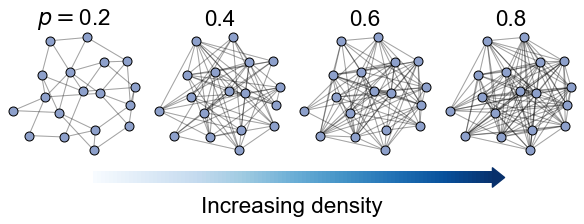

In [2]:
# describe ER model


np.random.seed(8888)
ps = [0.2, 0.4, 0.6, 0.8]
n_steps = len(ps)
fig, axs = plt.subplots(
    2,
    n_steps,
    figsize=(8, 3),
    gridspec_kw=dict(height_ratios=[2, 0.5]),
    constrained_layout=True,
)
n = 18
for i, p in enumerate(ps):
    A = er_np(n, p)
    if i == 0:
        node_data = pd.DataFrame(index=np.arange(n))

    ax = axs[0, i]
    networkplot_simple(A, node_data, ax=ax, compute_layout=i == 0)

    label_text = f"{p}"
    if i == 0:
        label_text = r"$p = $" + label_text
    ax.set_title(label_text)

fig.set_facecolor("w")


ax = merge_axes(fig, axs, rows=1)

soft_axis_off(ax)


def rainbowarrow(ax, start, end, cmap="viridis", n=500, lw=3):
    # REF: https://stackoverflow.com/questions/47163796/using-colormap-with-annotate-arrow-in-matplotlib
    cmap = plt.get_cmap(cmap, n)
    # Arrow shaft: LineCollection
    x = np.linspace(start[0], end[0], n)
    y = np.linspace(start[1], end[1], n)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, linewidth=lw)
    lc.set_array(np.linspace(0, 1, n))
    ax.add_collection(lc)
    # Arrow head: Triangle
    tricoords = [(0, -0.4), (0.5, 0), (0, 0.4), (0, -0.4)]
    angle = np.arctan2(end[1] - start[1], end[0] - start[0])
    rot = matplotlib.transforms.Affine2D().rotate(angle)
    tricoords2 = rot.transform(tricoords)
    tri = matplotlib.path.Path(tricoords2, closed=True)
    ax.scatter(end[0], end[1], c=1, s=(2 * lw) ** 2, marker=tri, cmap=cmap, vmin=0)
    ax.autoscale_view()


rainbowarrow(ax, (0.15, 0.5), (0.85, 0.5), cmap="Blues", n=100, lw=12)
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("Increasing density")

gluefig("er_explain", fig)

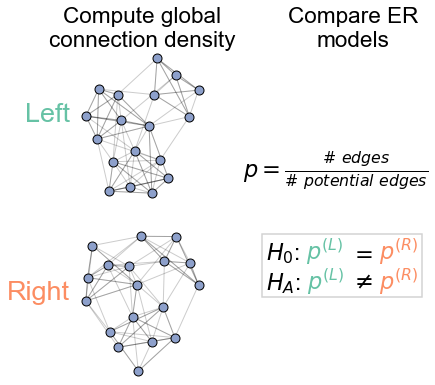

In [3]:
A1, A2, node_data = sample_toy_networks()
node_data["labels"] = np.ones(len(node_data), dtype=int)
palette = {1: sns.color_palette("Set2")[2]}
fig, axs = plt.subplots(2, 2, figsize=(6, 6), gridspec_kw=dict(wspace=0.7))

ax = axs[0, 0]
networkplot_simple(A1, node_data, ax=ax)

ax.set_title("Compute global\nconnection density")
ax.set_ylabel(
    "Left",
    color=network_palette["Left"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)


ax = axs[1, 0]
networkplot_simple(A2, node_data, ax=ax)

ax.set_ylabel(
    "Right",
    color=network_palette["Right"],
    size="large",
    rotation=0,
    ha="right",
    labelpad=10,
)

stat, pvalue, misc = erdos_renyi_test(A1, A2)


ax = axs[0, 1]
ax.text(
    0.4,
    0.2,
    r"$p = \frac{\# \ edges}{\# \ potential \ edges}$",
    ha="center",
    va="center",
)
ax.axis("off")


ax.set_title("Compare ER\nmodels")
ax.set(xlim=(-0.5, 2), ylim=(0, 1))


ax = axs[1, 1]
ax.axis("off")

x = 0
y = 0.55


draw_hypothesis_box("er", -0.2, 0.8, ax=ax, fontsize="medium", yskip=0.2)


gluefig("er_methods", fig)

In [4]:
stat, pvalue, misc = erdos_renyi_test(left_adj, right_adj)
glue("pvalue", pvalue)

In [5]:
n_possible_left = misc["possible1"]
n_possible_right = misc["possible2"]
glue("n_possible_left", n_possible_left)
glue("n_possible_right", n_possible_right)

density_left = misc["probability1"]
density_right = misc["probability2"]
glue("density_left", density_left)
glue("density_right", density_right)

n_edges_left = misc["observed1"]
n_edges_right = misc["observed2"]

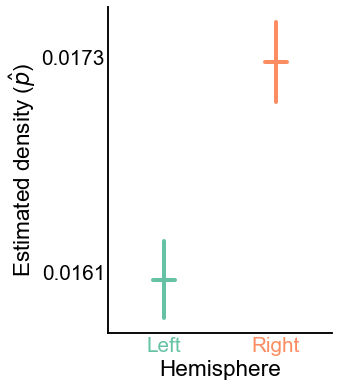

In [6]:

plot_density(misc, palette=network_palette)

gluefig("er_density", fig)

## Reject bilateral symmetry under the ER model


```{glue:figure} fig:er_unmatched_test-er_density
:name: "fig:er_unmatched_test-er_density"

Comparison of estimated densities for the left and right hemisphere networks. The
estimated density (probability of any edge across the entire network), $\hat{p}$, for
the left
hemisphere is ~{glue:text}`er_unmatched_test-density_left:0.3f`, while for the right
it is
~{glue:text}`er_unmatched_test-density_right:0.3f`. Black lines denote
{glue:text}`er_unmatched_test-coverage_percentage`**%**
confidence intervals for this estimated parameter $\hat{p}$. The p-value for testing
the null hypothesis that these densities are the same is
{glue:text}`er_unmatched_test-pvalue:0.3g` (two
sided Fisher's exact test).
```


{numref}`Figure {number} <fig:er_unmatched_test-er_density>` shows the comparison of
the network densities between the left and right hemisphere induced subgraphs. We see
that the density on the left is ~{glue:text}`er_unmatched_test-density_left:0.3f`, and
on the right it is ~{glue:text}`er_unmatched_test-density_right:0.3f`. To determine
whether this is a difference likely to be observed by chance under the ER model,
we ran a two-sided Fisher's exact test, which tests whether the success probabilities
between two independent binomials are significantly different. This test yields a
p-value of {glue:text}`er_unmatched_test-pvalue:0.3g`, suggesting that we have strong
evidence to reject this version of our hypotheis of bilateral symmetry. We note that
while the difference between estimated densities is not massive, this low p-value
results from the large sample size for this comparison. We note that there are
{glue:text}`er_unmatched_test-n_possible_left:,.0f` and
{glue:text}`er_unmatched_test-n_possible_right:,.0f` potential edges on the left and
right,
respectively, making the sample size for this comparison quite large.

To our knowledge, when neuroscientists have considered the question of bilateral
symmetry, they have not meant such a simple comparison of proportions. In many ways,
the ER model is too simple to be an interesting description of connectome structure.
However, we note that *even the simplest network model* yields a significant
difference between brain hemispheres for this organism. It is unclear whether this
difference in densities is biological (e.g. a result of slightly differing rates of
development for this individual), an artifact of how the data was collected (e.g.
technological limitations causing slightly lower reconstruction rates on the left
hemisphere), or something else entirely. Still, the ER test results also provide
important considerations for other tests. Almost any network statistic (e.g.
clustering coefficient, number of triangles, etc), as well as many of the model-based
parameters we will consider in this paper, are strongly related to the network
density. Thus, if the densities are different, it is likely that tests based on any
of these other test statistics will also reject the null hypothesis. Thus, we will
need ways of telling whether an observed difference for these other tests could be
explained by this difference in density alone.

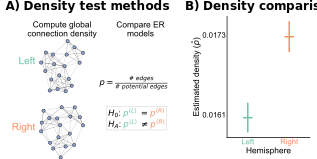

In [7]:

FIG_PATH = FIG_PATH / FILENAME

fontsize = 12

methods = SmartSVG(FIG_PATH / "er_methods.svg")
methods.set_width(200)
methods.move(10, 20)
methods_panel = Panel(
    methods, Text("A) Density test methods", 5, 10, size=fontsize, weight="bold")
)

density = SmartSVG(FIG_PATH / "er_density.svg")
density.set_height(methods.height)
density.move(10, 15)
density_panel = Panel(
    density, Text("B) Density comparison", 5, 10, size=fontsize, weight="bold")
)
density_panel.move(methods.width * 0.9, 0)

fig = Figure(
    (methods.width + density.width) * 0.9,
    (methods.height) * 0.9,
    methods_panel,
    density_panel,
)
fig.save(FIG_PATH / "composite.svg")
fig

In [8]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")

Script took 0:00:05.742603
Completed at 2022-03-21 10:00:32.244511
